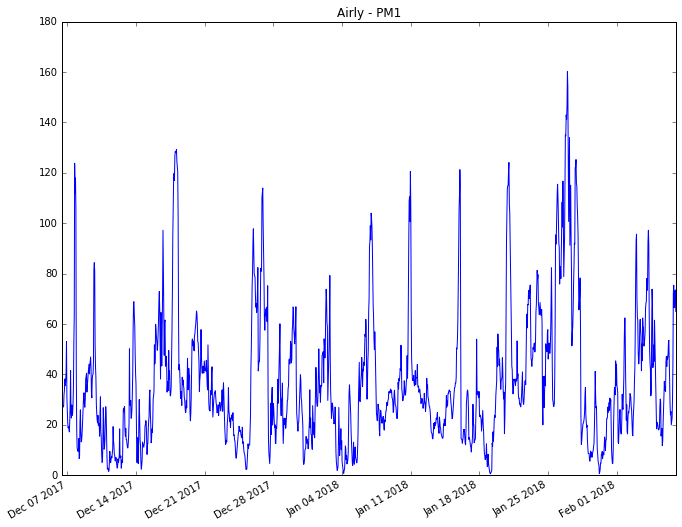

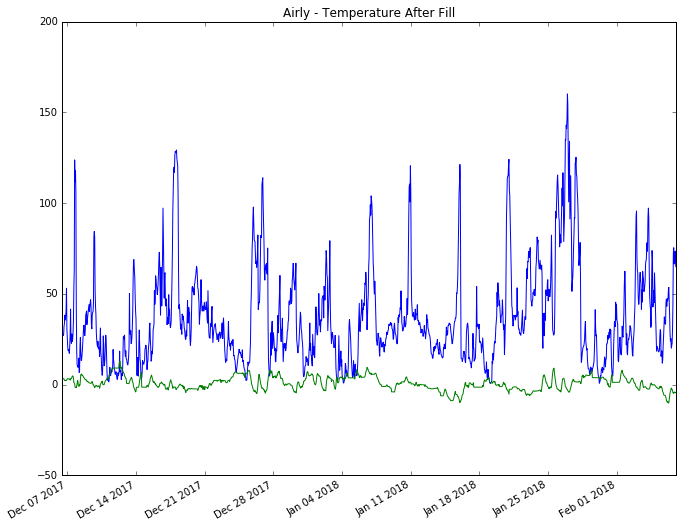

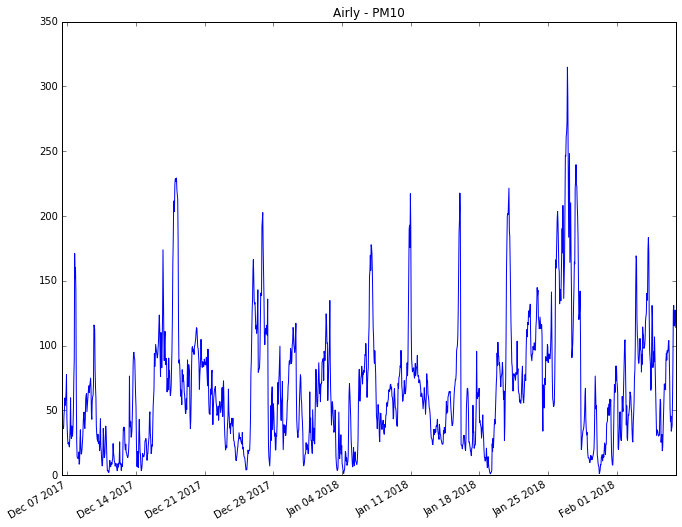

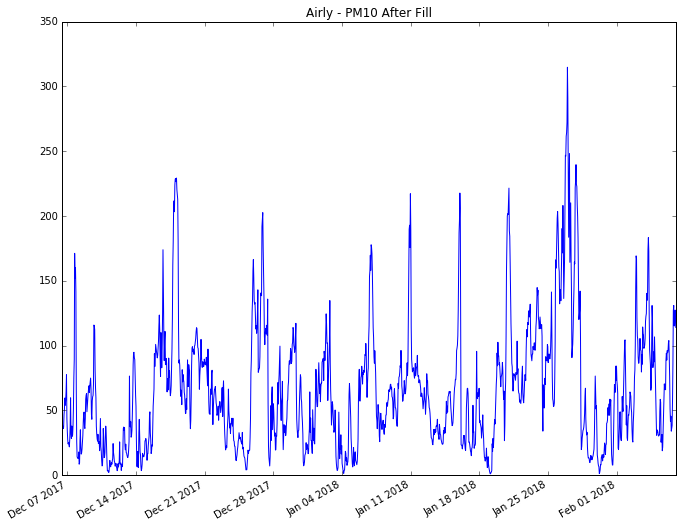

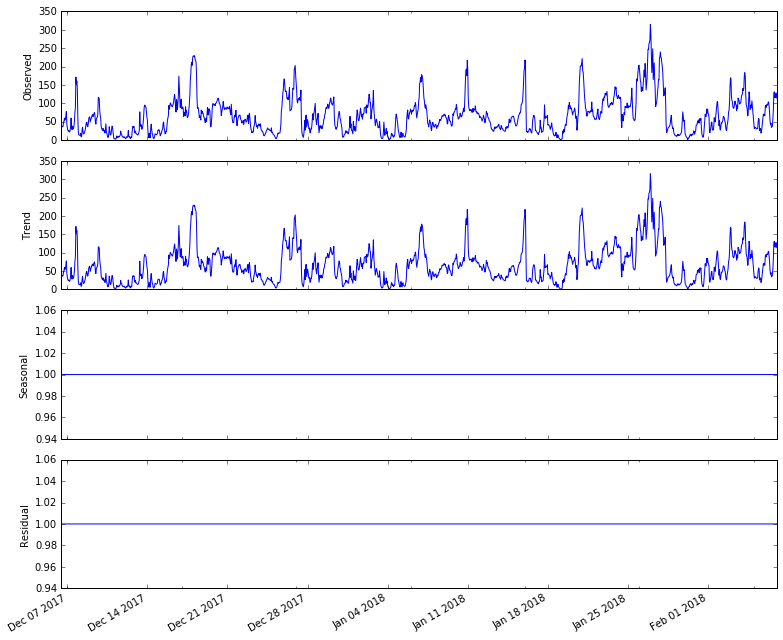

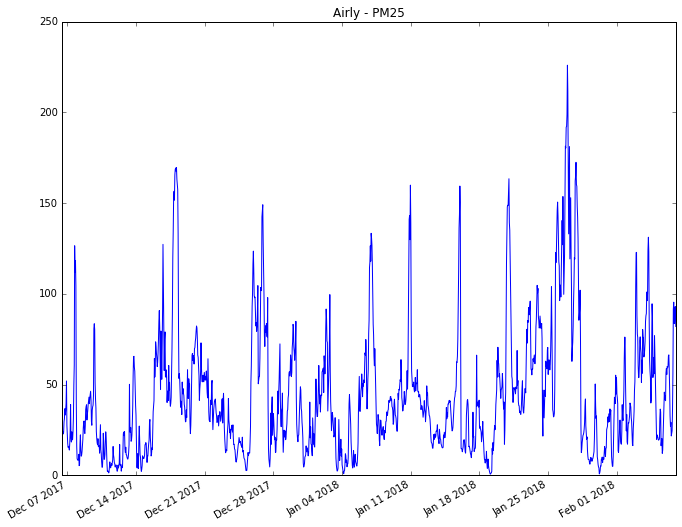

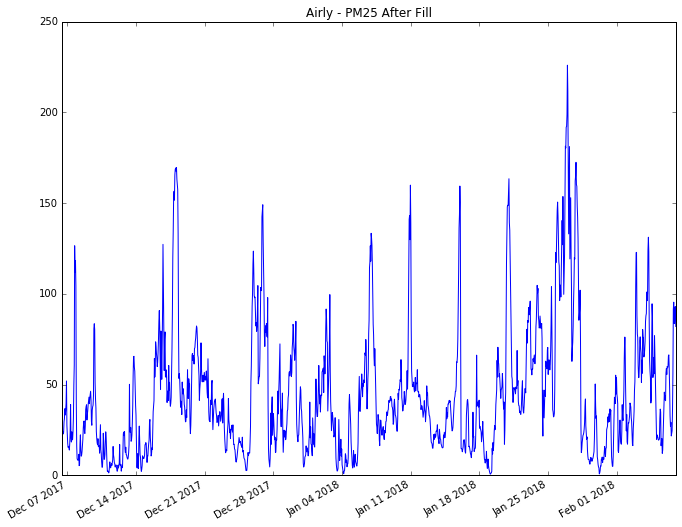

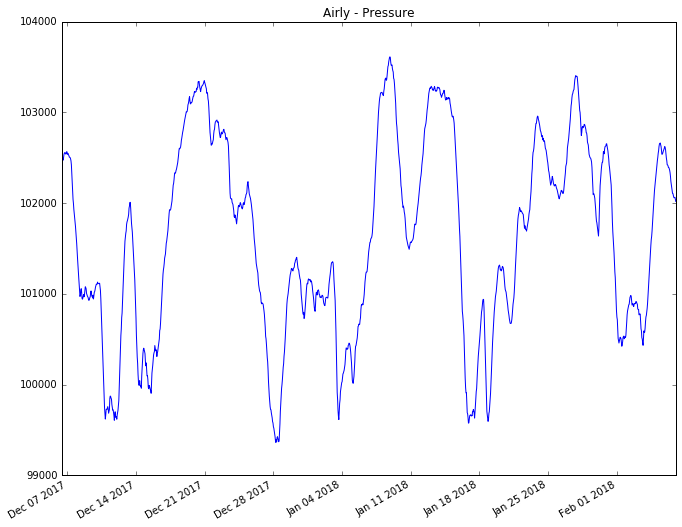

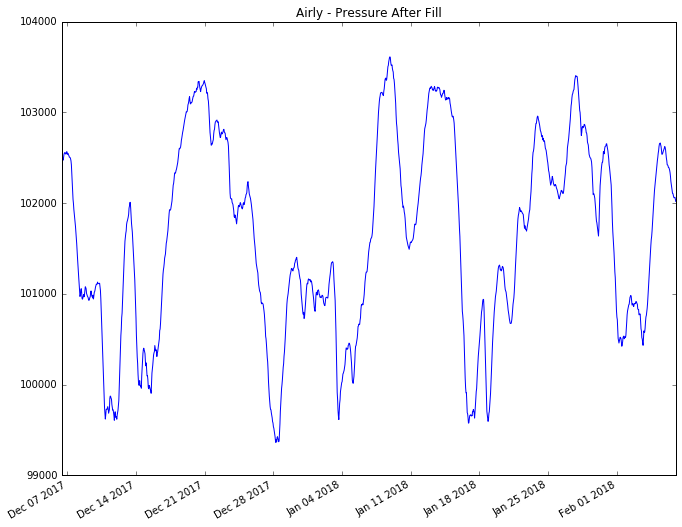

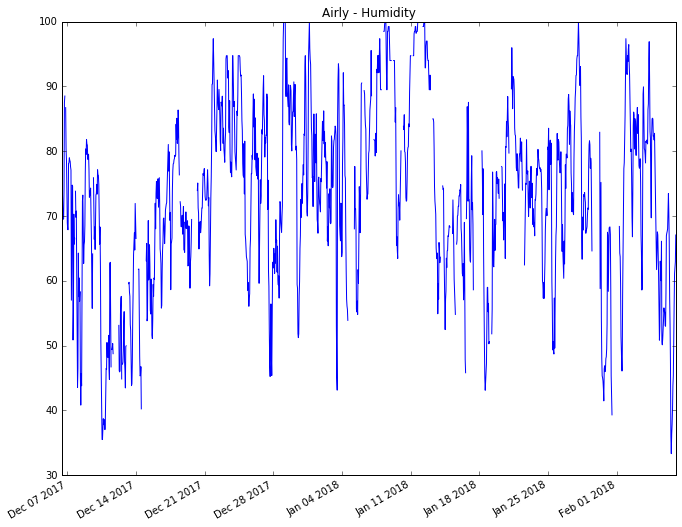

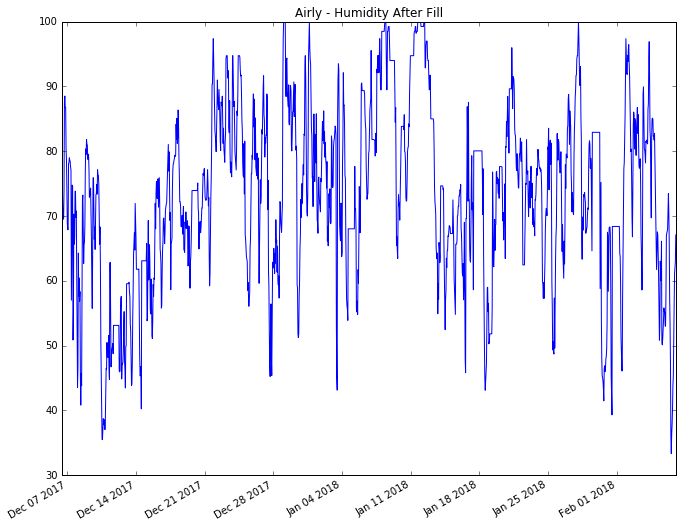

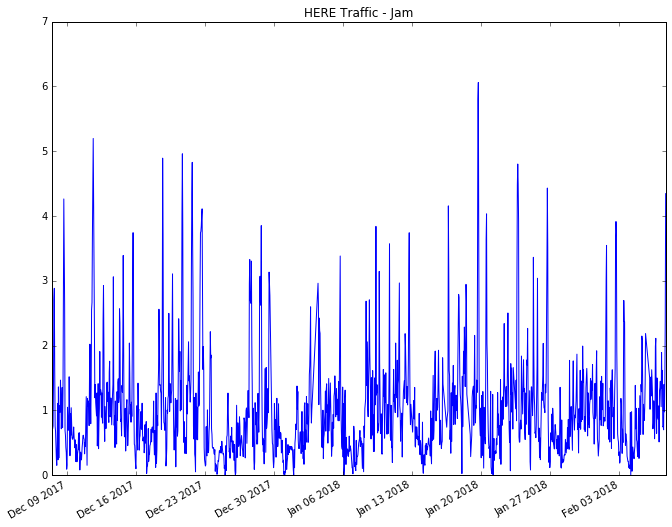

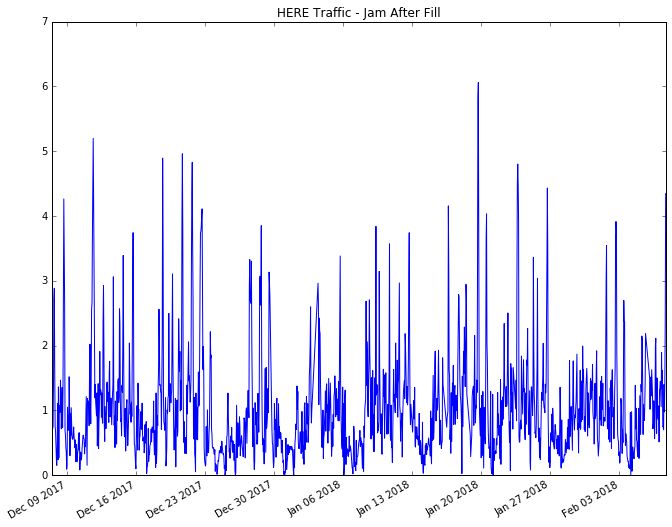

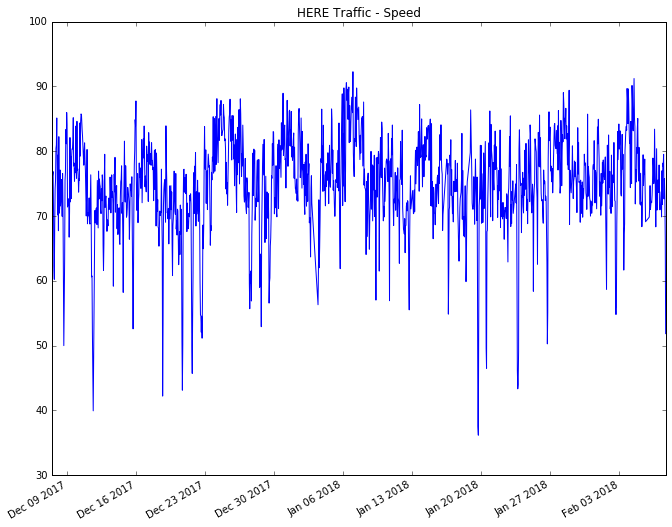

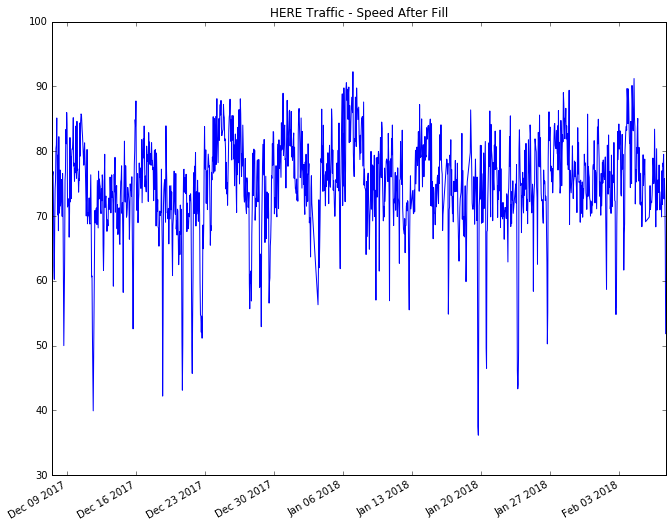

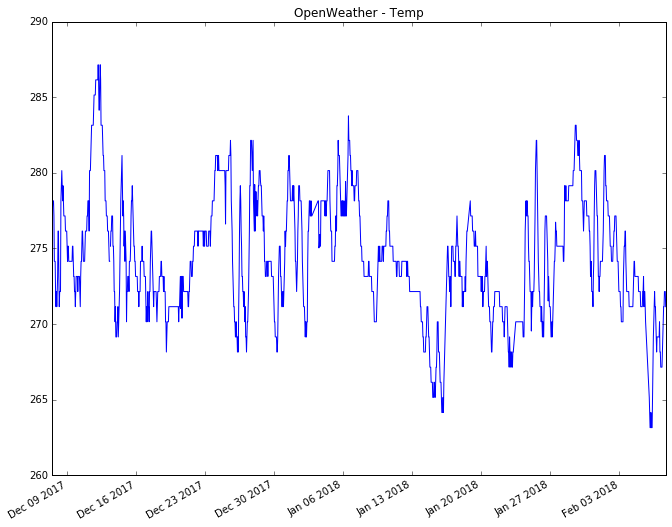

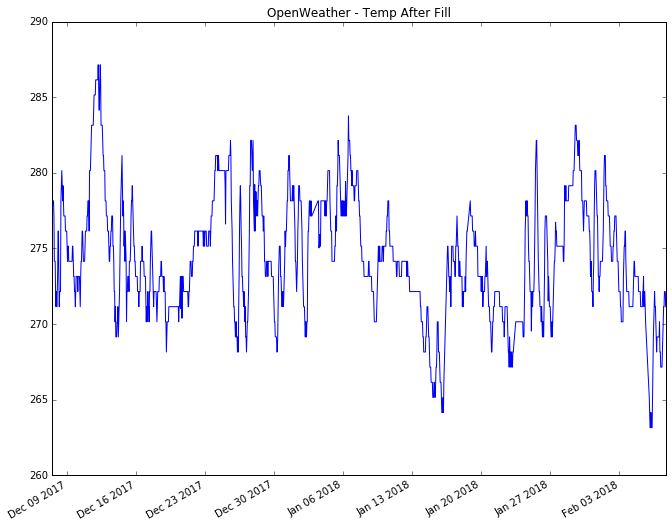

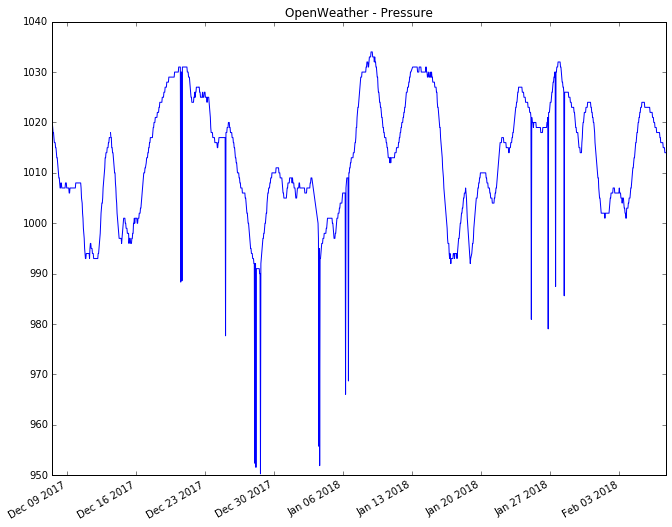

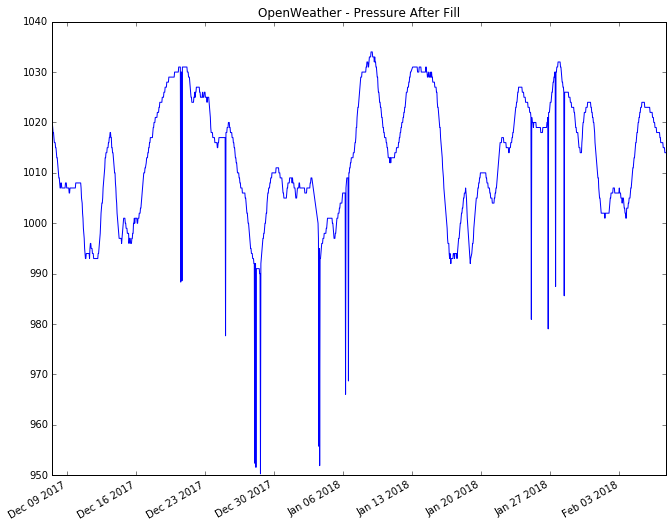

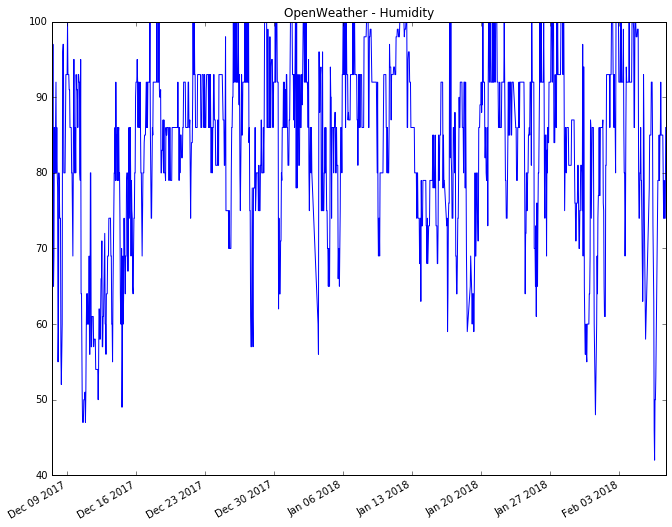

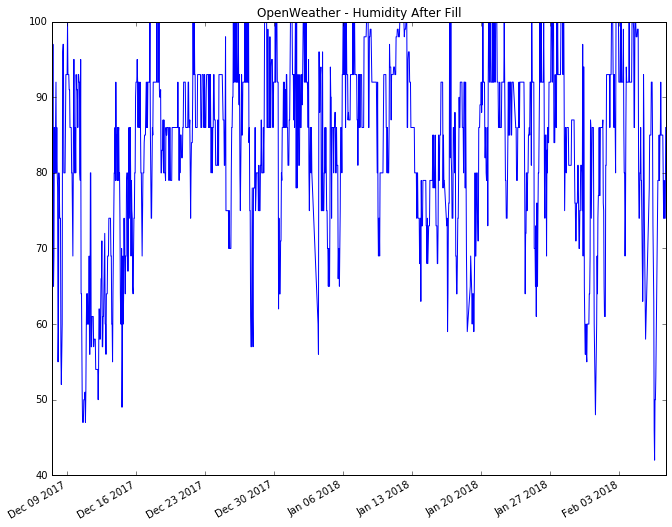

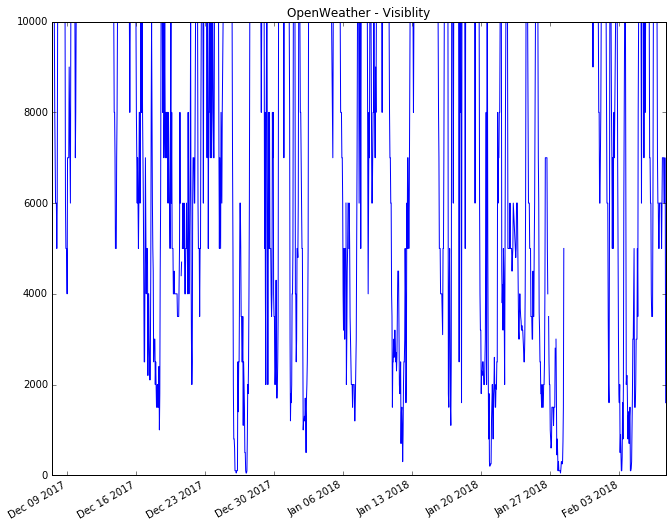

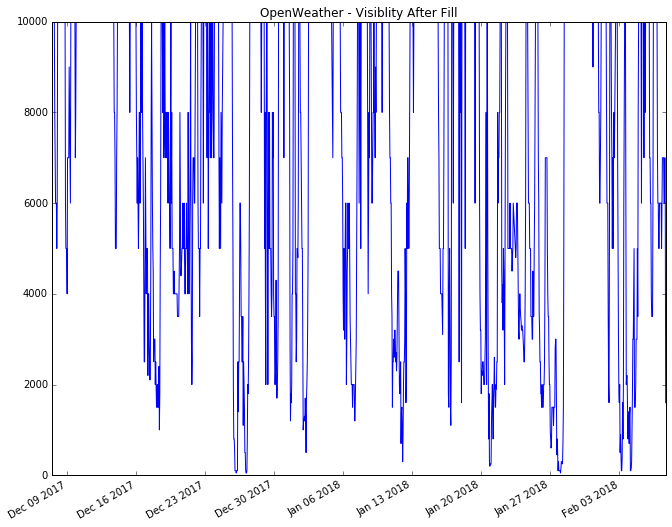

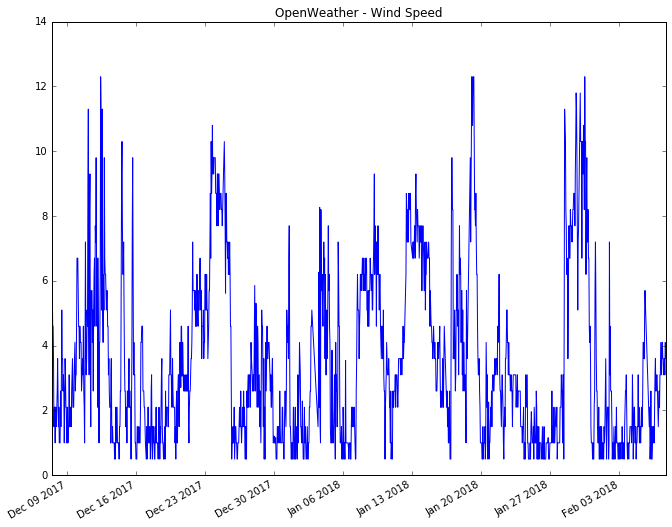

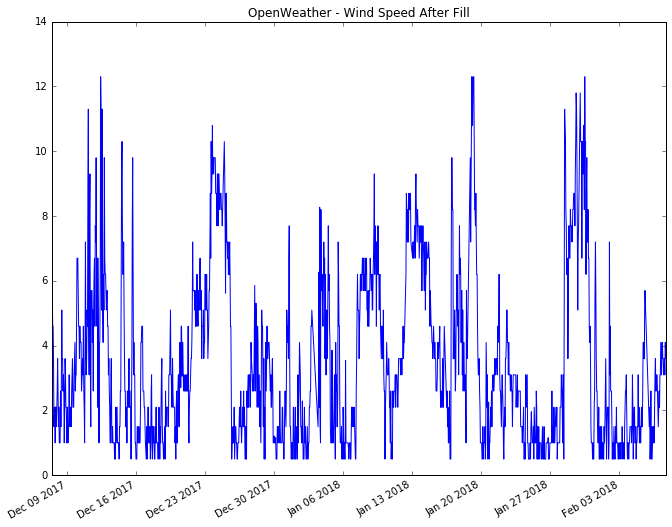

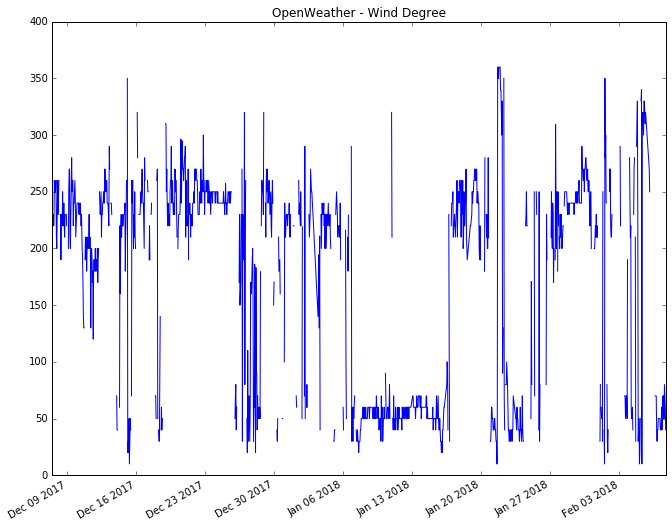

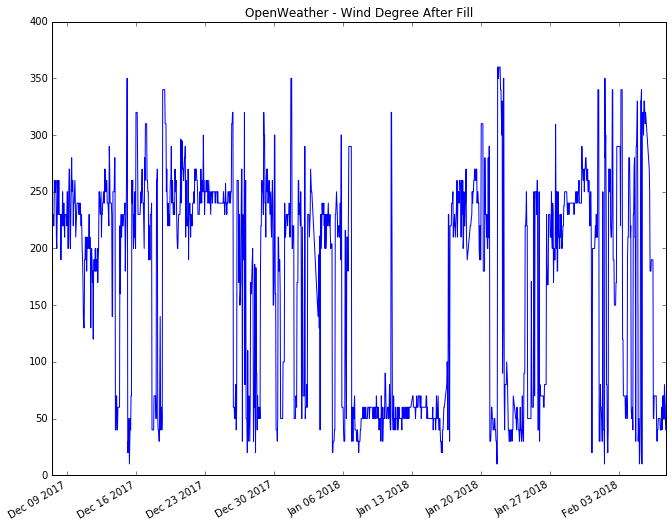

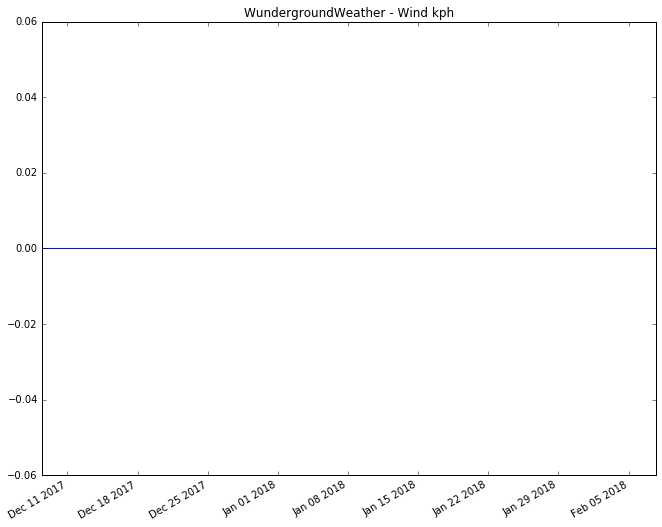

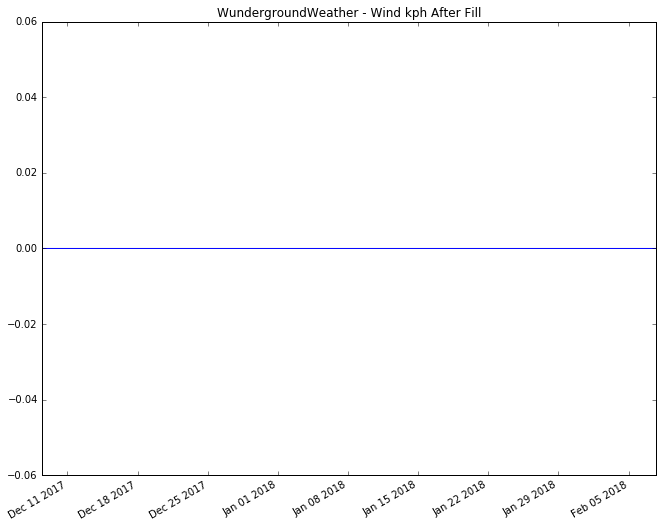

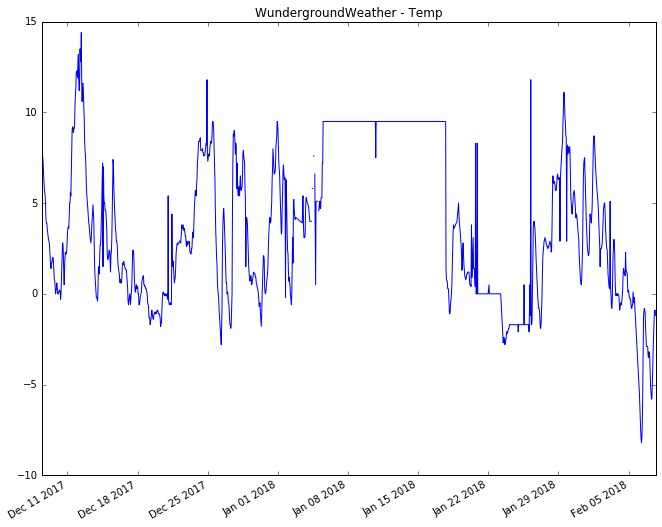

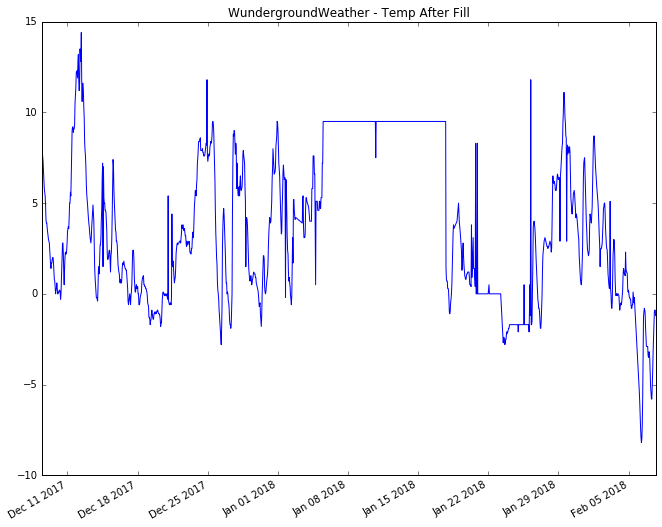

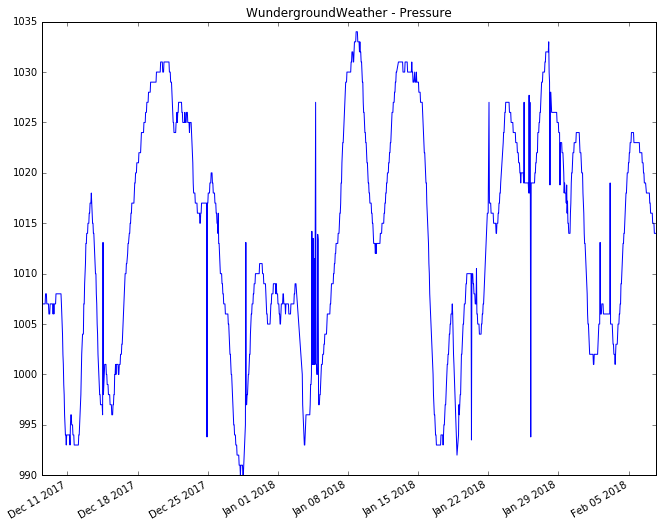

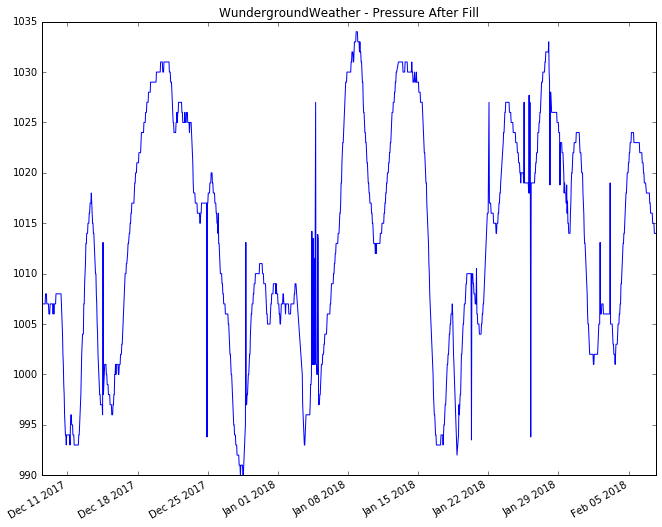

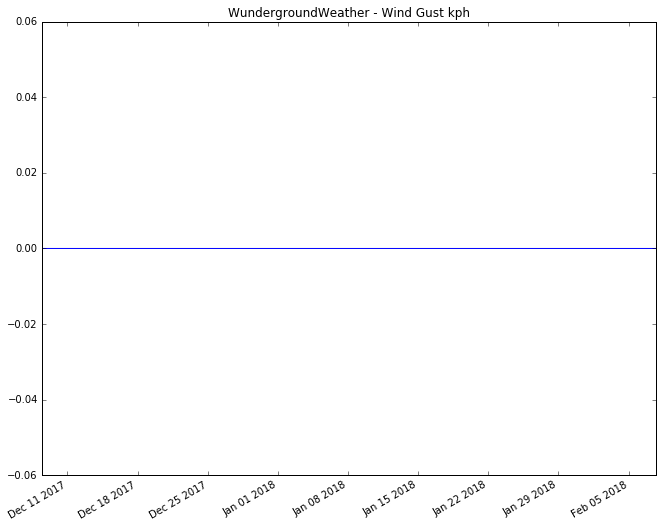

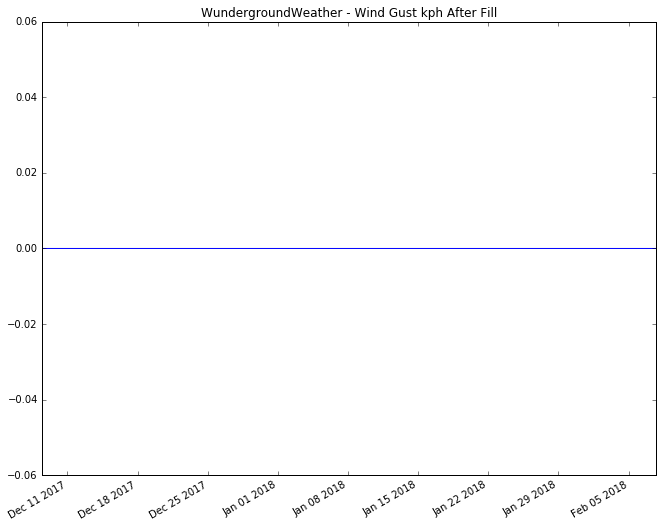

ValueError: could not convert string to float: '--'

In [13]:
import dateutil.parser
import gpxpy.geo
import statsmodels.api as sm

from matplotlib import pyplot
from pandas import Series
from pymongo import MongoClient
from pylab import rcParams

def display_airly_sensors(airly_sensors_db_collection):
    for airly_sensor in airly_sensors.find():
        print(airly_sensor['_id'],airly_sensor['address']['locality'],airly_sensor['address'].get('route'))

def time_series(extract_parameter_timestamp_function, extract_parameter_value_function, db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = extract_parameter_timestamp_function(measurement)
        if extract_parameter_value_function(measurement) != 'NA' and extract_parameter_value_function(measurement) != 'N/A':
            time_series[timestamp] = extract_parameter_value_function(measurement)
    return Series(time_series)

def traffic_speed_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        speed_sum = 0.0
        speed_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                speed_weight += flow_item['TMC']['LE']
                speed_sum += flow_item['TMC']['LE'] * flow_item['CF'][0]['SU']
        time_series[timestamp] = speed_sum / speed_weight
    return Series(time_series)

def traffic_jam_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        jam_sum = 0.0
        jam_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                jam_weight += flow_item['TMC']['LE']
                jam_sum += flow_item['TMC']['LE'] * flow_item['CF'][0]['JF']
        time_series[timestamp] = jam_sum / jam_weight
    return Series(time_series)


def find_nearest_wunderground_sensor_for_airly_sensor(airly_db_collection, wunderground_db_collection):
    mapping = {}
    for airly_sensor in airly_db_collection.find():
        min_dist = float('Inf')
        for wunder_sensor in wunderground_db_collection:
            dist = gpxpy.geo.haversine_distance(wunder_sensor['location']['latitude'], 
                                                wunder_sensor['location']['longitude'], 
                                                airly_sensor['location']['latitude'], 
                                                airly_sensor['location']['longitude'])
            if dist < min_dist:
                min_dist = dist
                mapping[str(airly_sensor['_id'])] = wunder_sensor['_id']
    return mapping

def extract_timestamp_from_airly_measurement(measurement):
    return dateutil.parser.parse(measurement['tillDateTime'])

def extract_timestamp_from_mongo_id(measurement):
    return measurement['_id'].generation_time

def extract_pm1_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm1')

def extract_pm10_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm10')

def extract_pm25_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm25')

def extract_pressure_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pressure')

def extract_temperature_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('temperature')

def extract_humidity_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('humidity')

def extract_temp_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('temp')

def extract_pressure_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('pressure')

def extract_humidity_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('humidity')

def extract_visibility_from_ow_measurement(measurement):
    return measurement.get('visibility')

def extract_wind_speed_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('speed')

def extract_wind_deg_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('deg')

def extract_windchill_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('windchill_c') != 'NA'):
        return measurement.get('current_observation',{}).get('windchill_c')

def extract_wind_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_kph')

def extract_wind_dir_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_dir')

def extract_visibility_km_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('visibility_km')

def extract_uv_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('UV')

def extract_temp_c_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('temp_c')

def extract_feelslike_c_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('feelslike_c') != ''):
        return measurement.get('current_observation',{}).get('feelslike_c')

def extract_relative_humidity_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('relative_humidity',"0%").replace('%', '')

def extract_pressure_mb_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('pressure_mb')

def extract_wind_gust_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_gust_kph')

def extract_precip_1hr_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_1hr_in') != ''):
        return measurement.get('current_observation',{}).get('precip_1hr_in')

def extract_precip_today_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_today_in') != ''):
        return measurement.get('current_observation',{}).get('precip_today_in')


client = MongoClient('localhost', 27017)
db = client['local']

airly_sensors = db['airly_sensors']
wunder_sensors = list(db['wunder_sensors_1'].find()) + list(db['wunder_sensors_2'].find())

airly_measurements = db['airly_sensors_measurements']
ow_weather_measurements = db['open_weather_measurements']
wunder_weather_measurements = db['wunder_sensors_measurements']
traffic_measurements = db['traffic_measurements']

nearest_wunder_sensors = find_nearest_wunderground_sensor_for_airly_sensor(airly_sensors, wunder_sensors)
lom_id = '195'
rcParams['figure.figsize'] = 11, 9

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm1_from_airly_measurement, airly_measurements, lom_id))
series.plot()
pyplot.title('Airly - PM1')
pyplot.show()

series = series.fillna(series.bfill())
ax = series.plot()
#pyplot.title('Airly - PM1 After Fill')
#pyplot.show()

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_temperature_from_airly_measurement, airly_measurements, lom_id))
#series.plot()
#pyplot.title('Airly - Temperature')
#pyplot.show()

series = series.fillna(series.bfill())
series.plot(ax=ax)
pyplot.title('Airly - Temperature After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm10_from_airly_measurement, airly_measurements, lom_id))
series.plot()
pyplot.title('Airly - PM10')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('Airly - PM10 After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm25_from_airly_measurement, airly_measurements, lom_id))
series.plot()
pyplot.title('Airly - PM25')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('Airly - PM25 After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pressure_from_airly_measurement, airly_measurements, lom_id))
series.plot()
pyplot.title('Airly - Pressure')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('Airly - Pressure After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_airly_measurement, extract_humidity_from_airly_measurement, airly_measurements, lom_id))
series.plot()
pyplot.title('Airly - Humidity')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('Airly - Humidity After Fill')
pyplot.show()

series = Series(traffic_jam_time_series(traffic_measurements, lom_id))
series.plot()
pyplot.title('HERE Traffic - Jam')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('HERE Traffic - Jam After Fill')
pyplot.show()

series = Series(traffic_speed_time_series(traffic_measurements, lom_id))
series.plot()
pyplot.title('HERE Traffic - Speed')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('HERE Traffic - Speed After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Temp')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Temp After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_pressure_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Pressure')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Pressure After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_humidity_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Humidity')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Humidity After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_visibility_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Visiblity')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Visiblity After Fill')
pyplot.show()
             
series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_speed_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Wind Speed')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Wind Speed After Fill')
pyplot.show()
             
series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_deg_from_ow_measurement, ow_weather_measurements, lom_id))
series.plot()
pyplot.title('OpenWeather - Wind Degree')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('OpenWeather - Wind Degree After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_kph_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series.plot()
pyplot.title('WundergroundWeather - Wind kph')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Wind kph After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_c_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series.plot()
pyplot.title('WundergroundWeather - Temp')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Temp After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_pressure_mb_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Pressure')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Pressure After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_gust_kph_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Wind Gust kph')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Wind Gust kph After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_uv_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - UV')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - UV After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_visibility_km_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Visibility')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Visibility After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_relative_humidity_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Humidity')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Humidity After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_windchill_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Windchill')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Windchill After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_feelslike_c_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Feelslike')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Feelslike After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_precip_1hr_in_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Precip 1h Inches')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Precip 1h Inches After Fill')
pyplot.show()

series = Series(time_series(extract_timestamp_from_mongo_id, extract_precip_today_in_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
series = series.astype(float)
series.plot()
pyplot.title('WundergroundWeather - Precip Today Inches')
pyplot.show()

series = series.fillna(series.bfill())
series.plot()
pyplot.title('WundergroundWeather - Precip Today Inches After Fill')
pyplot.show()

#series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_dir_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
#print(series)

#decomposition = sm.tsa.seasonal_decompose(series, model='additive')
#fig = decomposition.plot()
#pyplot.show()

In [ ]:
import dateutil.parser
import gpxpy.geo
import statsmodels.api as sm

from itertools import tee
from itertools import combinations
from matplotlib import pyplot
from pandas import Series, reset_option, set_option
from pymongo import MongoClient
from pylab import rcParams

def print_full(x):
    set_option('display.max_rows', len(x))
    print(x)
    reset_option('display.max_rows')

def time_series(extract_parameter_timestamp_function, extract_parameter_value_function, db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = extract_parameter_timestamp_function(measurement)
        if extract_parameter_value_function(measurement) != 'NA' and extract_parameter_value_function(measurement) != 'N/A':
            time_series[timestamp] = extract_parameter_value_function(measurement)
    return Series(time_series)

def traffic_speed_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        speed_sum = 0.0
        speed_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                speed_weight += flow_item['TMC']['LE']
                speed_sum += flow_item['TMC']['LE'] * flow_item['CF'][0].get('SU', 1.0)
        time_series[timestamp] = speed_sum / speed_weight
    return Series(time_series)

def traffic_jam_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        jam_sum = 0.0
        jam_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                jam_weight += flow_item['TMC']['LE']
                jam_sum += flow_item['TMC']['LE'] * flow_item['CF'][0]['JF']
        time_series[timestamp] = jam_sum / jam_weight
    return Series(time_series)


def find_nearest_wunderground_sensor_for_airly_sensor(airly_db_collection, wunderground_db_collection):
    mapping = {}
    for airly_sensor in airly_db_collection.find():
        min_dist = float('Inf')
        for wunder_sensor in wunderground_db_collection:
            dist = gpxpy.geo.haversine_distance(wunder_sensor['location']['latitude'], 
                                                wunder_sensor['location']['longitude'], 
                                                airly_sensor['location']['latitude'], 
                                                airly_sensor['location']['longitude'])
            if dist < min_dist:
                min_dist = dist
                mapping[str(airly_sensor['_id'])] = wunder_sensor['_id']
    return mapping

def extract_timestamp_from_airly_measurement(measurement):
    return dateutil.parser.parse(measurement['tillDateTime'])

def extract_timestamp_from_mongo_id(measurement):
    return measurement['_id'].generation_time

def extract_pm1_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm1', 0.0)

def extract_pm10_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm10', 0.0)

def extract_pm25_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm25', 0.0)

def extract_pressure_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pressure', 0.0)

def extract_temperature_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('temperature', 0.0)

def extract_humidity_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('humidity',0.0)

def extract_temp_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('temp')

def extract_pressure_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('pressure')

def extract_humidity_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('humidity')

def extract_visibility_from_ow_measurement(measurement):
    return measurement.get('visibility')

def extract_wind_speed_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('speed')

def extract_wind_deg_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('deg')

def extract_windchill_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('windchill_c', '0.0').replace('NA', '0.0')

def extract_wind_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_kph')

def extract_wind_dir_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_dir')

def extract_visibility_km_from_wunder_measurement(measurement):
    if measurement.get('current_observation',{}).get('visibility_km') != 'N/A' and measurement.get('current_observation',{}).get('visibility_km') != '':
        return measurement.get('current_observation',{}).get('visibility_km')

def extract_uv_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('UV','0.0').replace('--','0.0')

def extract_temp_c_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('temp_c')

def extract_feelslike_c_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('feelslike_c') != ''):
        return measurement.get('current_observation',{}).get('feelslike_c')

def extract_relative_humidity_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('relative_humidity',"0%").replace('%', '')

def extract_pressure_mb_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('pressure_mb')

def extract_wind_gust_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_gust_kph')

def extract_precip_1hr_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_1hr_in') != ''):
        return measurement.get('current_observation',{}).get('precip_1hr_in')

def extract_precip_today_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_today_in') != ''):
        return measurement.get('current_observation',{}).get('precip_today_in')

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def compute_assocation_rule_coefficient(param1_key, param2_key, param1_time_series, param2_time_series, sigma_1, sgima_2, lag):
    param1_derivatives = []
    param2_derivatives = []
    
    for tuplee in pairwise(param1_time_series):
        if tuplee[0] == 0:
            val = tuplee[1]
        else:
            val = (tuplee[1] - tuplee[0]) / tuplee[0]
        if val > -sigma_1 and val < sigma_1:
            param1_derivatives.append(0)
        elif val >= sigma_1:
            param1_derivatives.append(1)
        else:
            param1_derivatives.append(-1)

    for tuplee in pairwise(param2_time_series):
        if tuplee[0] == 0:
            val = tuplee[1]
        else:
            val = (tuplee[1] - tuplee[0]) / tuplee[0]
        if val > -sgima_2 and val < sgima_2:
            param2_derivatives.append(0)
        elif val >= sgima_2:
            param2_derivatives.append(1)
        else:
            param2_derivatives.append(-1)

    research_length = min(len(param1_derivatives),len(param2_derivatives)) - lag

    d = 1
    ii = 1
    e = 1
    f = 1
    n = 1

    for i in range(research_length):
        if (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == 1) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == -1):
            d+= 1
        elif (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == -1) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == 1):
            ii+= 1
        elif (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == 1) or (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == -1):
            e+= 1
        elif (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == 0) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == 0):
            f+= 1
        elif (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == 0):
            n+= 1
    if (abs(d/research_length - ii/research_length) >= 0.2):
        print(param1_key, ',', param2_key, ',',d, ',', ii, ',', e, ',',f, ',',n)

    a_d = d / (research_length)
    a_i = ii / (research_length)
    or_d = d * n / (e * f)
    or_i = ii / (e * f)

    
    
client = MongoClient('localhost', 27017)
db = client['local']
time_series_dict = {}

airly_sensors = db['airly_sensors']
airly_measurements = db['airly_sensors_measurements']

for airly_sensor in airly_sensors.find():
    lom_id = str(airly_sensor['_id'])
    print(lom_id)
    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm1_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive', ).trend
    time_series_dict['pm1'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_temperature_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['airly-tmp'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm10_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['pm10'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm25_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['pm25'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pressure_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['airly-pressure'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_humidity_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['airly-humidity'] = series

    series = Series(traffic_jam_time_series(traffic_measurements, lom_id))
    series = series.fillna(series.bfill())
    if not series.empty:
        series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
        time_series_dict['here-traffic-jam'] = series

    series = Series(traffic_speed_time_series(traffic_measurements, lom_id))
    series = series.fillna(series.bfill())
    if not series.empty:
        series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
        time_series_dict['here-traffic-speed'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-temp'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_pressure_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-press'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_humidity_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-humidity'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_visibility_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-vis'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_speed_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-wind'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_kph_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-wind'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_c_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-tmp'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_pressure_mb_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-pressure'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_wind_gust_kph_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-wind-gust'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_uv_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-uv'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_visibility_km_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-vis'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_relative_humidity_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-hum'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_windchill_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-windchill'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_feelslike_c_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-feelslike'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_precip_1hr_in_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-precip1h'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_precip_today_in_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.astype(float)
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-precipday'] = series

    for combination in combinations(time_series_dict.keys(), 2):
        compute_assocation_rule_coefficient(combination[0], combination[1], time_series_dict[combination[0]], time_series_dict[combination[1]], 0.01, 0.01, 0)

#tmp_series = tmp_series.fillna(tmp_series.bfill())
#tmp_series = sm.tsa.seasonal_decompose(tmp_series, model='additive').trend


In [ ]:
import dateutil.parser
import gpxpy.geo
import statsmodels.api as sm

from itertools import tee
from itertools import combinations
from matplotlib import pyplot
from pandas import Series, reset_option, set_option
from pymongo import MongoClient
from pylab import rcParams

def print_full(x):
    set_option('display.max_rows', len(x))
    print(x)
    reset_option('display.max_rows')

def time_series(extract_parameter_timestamp_function, extract_parameter_value_function, db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = extract_parameter_timestamp_function(measurement)
        if extract_parameter_value_function(measurement) != 'NA' and extract_parameter_value_function(measurement) != 'N/A':
            time_series[timestamp] = extract_parameter_value_function(measurement)
    return Series(time_series)

def traffic_speed_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        speed_sum = 0.0
        speed_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                speed_weight += flow_item['TMC']['LE']
                speed_sum += flow_item['TMC']['LE'] * flow_item['CF'][0].get('SU', 1.0)
        time_series[timestamp] = speed_sum / speed_weight
    return Series(time_series)

def traffic_jam_time_series(db_collection, lom_id):
    time_series = {}
    for measurement in db_collection.find({'lom_id':lom_id}):
        timestamp = dateutil.parser.parse(measurement['CREATED_TIMESTAMP'])
        jam_sum = 0.0
        jam_weight = 0.0
        for roadway in measurement['RWS'][0]['RW']:
            for flow_item in roadway['FIS'][0]['FI']:
                jam_weight += flow_item['TMC']['LE']
                jam_sum += flow_item['TMC']['LE'] * flow_item['CF'][0]['JF']
        time_series[timestamp] = jam_sum / jam_weight
    return Series(time_series)


def find_nearest_wunderground_sensor_for_airly_sensor(airly_db_collection, wunderground_db_collection):
    mapping = {}
    for airly_sensor in airly_db_collection.find():
        min_dist = float('Inf')
        for wunder_sensor in wunderground_db_collection:
            dist = gpxpy.geo.haversine_distance(wunder_sensor['location']['latitude'], 
                                                wunder_sensor['location']['longitude'], 
                                                airly_sensor['location']['latitude'], 
                                                airly_sensor['location']['longitude'])
            if dist < min_dist:
                min_dist = dist
                mapping[str(airly_sensor['_id'])] = wunder_sensor['_id']
    return mapping

def extract_timestamp_from_airly_measurement(measurement):
    return dateutil.parser.parse(measurement['tillDateTime'])

def extract_timestamp_from_mongo_id(measurement):
    return measurement['_id'].generation_time

def extract_pm1_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm1', 0.0)

def extract_pm10_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm10', 0.0)

def extract_pm25_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pm25', 0.0)

def extract_pressure_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('pressure', 0.0)

def extract_temperature_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('temperature', 0.0)

def extract_humidity_from_airly_measurement(measurement):
    return measurement.get('measurements',{}).get('humidity',0.0)

def extract_temp_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('temp')

def extract_pressure_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('pressure')

def extract_humidity_from_ow_measurement(measurement):
    return measurement.get('main',{}).get('humidity')

def extract_visibility_from_ow_measurement(measurement):
    return measurement.get('visibility')

def extract_wind_speed_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('speed')

def extract_wind_deg_from_ow_measurement(measurement):
    return measurement.get('wind',{}).get('deg')

def extract_windchill_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('windchill_c', '0.0').replace('NA', '0.0')

def extract_wind_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_kph')

def extract_wind_dir_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_dir')

def extract_visibility_km_from_wunder_measurement(measurement):
    if measurement.get('current_observation',{}).get('visibility_km') != 'N/A' and measurement.get('current_observation',{}).get('visibility_km') != '':
        return measurement.get('current_observation',{}).get('visibility_km')

def extract_uv_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('UV','0.0').replace('--','0.0')

def extract_temp_c_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('temp_c')

def extract_feelslike_c_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('feelslike_c') != ''):
        return measurement.get('current_observation',{}).get('feelslike_c')

def extract_relative_humidity_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('relative_humidity',"0%").replace('%', '')

def extract_pressure_mb_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('pressure_mb')

def extract_wind_gust_kph_from_wunder_measurement(measurement):
    return measurement.get('current_observation',{}).get('wind_gust_kph')

def extract_precip_1hr_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_1hr_in') != ''):
        return measurement.get('current_observation',{}).get('precip_1hr_in')

def extract_precip_today_in_from_wunder_measurement(measurement):
    if (measurement.get('current_observation',{}).get('precip_today_in') != ''):
        return measurement.get('current_observation',{}).get('precip_today_in')

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def compute_assocation_rule_coefficient(param1_key, param2_key, param1_time_series, param2_time_series, sigma_1, sgima_2, lag):
    param1_derivatives = []
    param2_derivatives = []
    
    for tuplee in pairwise(param1_time_series):
        if tuplee[0] == 0:
            val = tuplee[1]
        else:
            val = (tuplee[1] - tuplee[0]) / tuplee[0]
        if val > -sigma_1 and val < sigma_1:
            param1_derivatives.append(0)
        elif val >= sigma_1:
            param1_derivatives.append(1)
        else:
            param1_derivatives.append(-1)

    for tuplee in pairwise(param2_time_series):
        if tuplee[0] == 0:
            val = tuplee[1]
        else:
            val = (tuplee[1] - tuplee[0]) / tuplee[0]
        if val > -sgima_2 and val < sgima_2:
            param2_derivatives.append(0)
        elif val >= sgima_2:
            param2_derivatives.append(1)
        else:
            param2_derivatives.append(-1)

    research_length = min(len(param1_derivatives),len(param2_derivatives)) - lag

    d = 1
    ii = 1
    e = 1
    f = 1
    n = 1

    for i in range(research_length):
        if (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == 1) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == -1):
            d+= 1
        elif (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == -1) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == 1):
            ii+= 1
        elif (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == 1) or (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == -1):
            e+= 1
        elif (param1_derivatives[i] == 1 and param2_derivatives[i + lag] == 0) or (param1_derivatives[i] == -1 and param2_derivatives[i + lag] == 0):
            f+= 1
        elif (param1_derivatives[i] == 0 and param2_derivatives[i + lag] == 0):
            n+= 1
    if (abs(d/research_length - ii/research_length) >= 0.2):
        print(param1_key, ',', param2_key, ',',d, ',', ii, ',', e, ',',f, ',',n)

    a_d = d / (research_length)
    a_i = ii / (research_length)
    or_d = d * n / (e * f)
    or_i = ii / (e * f)

    
    
client = MongoClient('localhost', 27017)
db = client['local']
time_series_dict = {}

airly_sensors = db['airly_sensors']
airly_measurements = db['airly_sensors_measurements']

for airly_sensor in airly_sensors.find():
    lom_id = str(airly_sensor['_id'])
    print(lom_id)
    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_pm1_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive', ).trend
    time_series_dict['pm1'] = series

    series = Series(time_series(extract_timestamp_from_airly_measurement, extract_temperature_from_airly_measurement, airly_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = series.truncate(before='2017-12-07 10:25:19+00:00')
    series = sm.tsa.seasonal_decompose(series, model='additive').trend
    time_series_dict['airly-tmp'] = series

    series = Series(traffic_jam_time_series(traffic_measurements, lom_id))
    series = series.fillna(series.bfill())
    if not series.empty:
        series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
        time_series_dict['here-traffic-jam'] = series

    series = Series(traffic_speed_time_series(traffic_measurements, lom_id))
    series = series.fillna(series.bfill())
    if not series.empty:
        series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
        time_series_dict['here-traffic-speed'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_from_ow_measurement, ow_weather_measurements, lom_id))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['ow-temp'] = series

    series = Series(time_series(extract_timestamp_from_mongo_id, extract_temp_c_from_wunder_measurement, wunder_weather_measurements, nearest_wunder_sensors[lom_id]))
    series = series.fillna(series.bfill())
    series = sm.tsa.seasonal_decompose(series, model='additive', freq=1).trend
    time_series_dict['wdg-tmp'] = series

#tmp_series = tmp_series.fillna(tmp_series.bfill())
#tmp_series = sm.tsa.seasonal_decompose(tmp_series, model='additive').trend
